In [1]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import time

import numpy as np

In [2]:
names = open('../data/names.txt', 'r').read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chs = sorted(set(''.join(names)))
stoi = {s: i+1 for i, s in enumerate(chs)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

In [4]:
#create data set
X, y = [], []

block_size = 7
emb_size = 6
emb_cat_size = block_size * emb_size


for name in names:
    
    context = [0] * block_size
    
    for ch in name + '.':
        
        idx = stoi[ch]
        
        X.append(context)
        y.append(idx)
        
        
        context = context[1:] + [idx]      
        
X = torch.tensor(X)
y = torch.tensor(y)

# X

In [5]:
X.shape

torch.Size([228146, 7])

In [6]:
C = torch.randn(27, emb_size)

In [7]:
X.shape

torch.Size([228146, 7])

In [8]:
W1 = torch.randn(emb_cat_size, 5000) #6 x 100
b1 = torch.randn(5000) #1 x 100

In [9]:
W2 = torch.randn(5000, 27)
b2 = torch.randn(27)

In [10]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [11]:
f"# of parameters = {sum(p.nelement() for p in parameters)}"

'# of parameters = 350189'

In [12]:
emb = C[X].view(-1, emb_cat_size)

In [13]:
h = torch.tanh(emb @ W1 + b1) # 32 x 100

In [14]:
logits = h @ W2 + b2

loss = F.cross_entropy(logits, y)
loss

tensor(118.2992, grad_fn=<NllLossBackward0>)

In [15]:
for p in parameters:
    p.grad = None

In [16]:
loss.backward()

In [17]:
for p in parameters:
    p.data += -0.01 * p.grad

In [18]:
print(loss.item())

118.29915618896484


In [21]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

C = torch.randn(27, emb_size, device=device)

W1 = torch.randn(emb_cat_size, 100, device=device) #6 x 100
b1 = torch.randn(100, device=device) #1 x 100

W2 = torch.randn(100, 27, device=device)
b2 = torch.randn(27, device=device)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [69]:
startTime = time.time()

for i in range(200_000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    emb = C[X[ix]].view(-1, emb_cat_size).to(device)

    h = torch.tanh(emb @ W1 + b1) # 32 x 100

    logits = h @ W2 + b2

    loss = F.cross_entropy(logits, y.to(device)[ix])
    if i % 10_000 == 0:
        print(loss.item())

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad.to(device)
        
endTime = time.time()

totalTime = endTime - startTime
totalTime

2.444732904434204
2.3186709880828857
2.6194827556610107
2.479647636413574
1.9407607316970825
2.1868958473205566
2.6487743854522705
2.1424546241760254
2.5598602294921875
2.1563127040863037
2.32039737701416
2.280773162841797
2.4730255603790283
2.6773934364318848
2.486020803451538
1.9613206386566162
2.1733033657073975
1.7908669710159302
2.208547592163086
2.4667906761169434


154.72027921676636

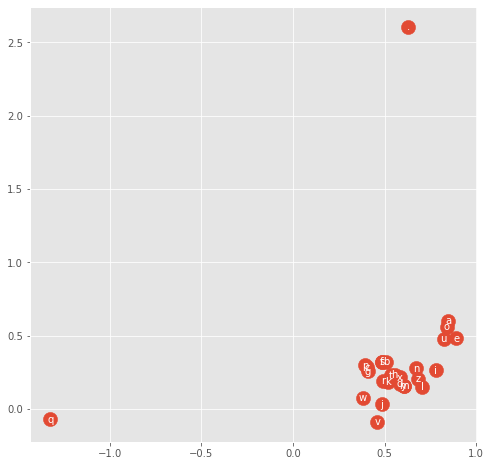

In [67]:
z = C.detach().cpu().numpy()

z.shape

plt.figure(figsize=(8, 8))
plt.scatter(z[:, 2].data, z[:, 3].data, s=200)
for i in range(z.shape[0]):
    plt.text(z[i, 2].item(), z[i, 3].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')    

In [68]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))



careah.
aabyil.
khiimr.
xheety.
salas.
keja.
hutefape.
artiiahei.
nermara.
ceriiv.
kalegy.
dham.
join.
quilt.
sroilea.
jadiq.
wazero.
dearyni.
ficenni.
satle.


In [73]:
num = np.array([2.444732904434204,
2.3186709880828857,
2.6194827556610107,
2.479647636413574,
1.9407607316970825,
2.1868958473205566,
2.6487743854522705,
2.1424546241760254,
2.5598602294921875,
2.1563127040863037,
2.32039737701416,
2.280773162841797,
2.4730255603790283,
2.6773934364318848,
2.486020803451538,
1.9613206386566162,
2.1733033657073975,
1.7908669710159302,
2.208547592163086,
2.4667906761169434])
sum(num)/ num.shape[0]


2.3168016195297243